In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

from xgboost import XGBClassifier, plot_tree
import xgboost as xgb

from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import pickle

### Importation CSV

In [156]:
df = pd.read_csv('../Files/SBAclean.csv')
df.MIS_Status = df.MIS_Status.replace({'P I F':1,'CHGOFF':0})
df.columns

Index(['State', 'BankState', 'NAICS', 'ApprovalFY', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural', 'MIS_Status',
       'GrAppv', 'Franchise'],
      dtype='object')

### Train Test Split

In [157]:
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.9, random_state=42, stratify=y)

### Dummy Classifier

In [158]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.8285372942298193

### Pipeline

In [159]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### RandomForest

In [160]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier( 
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90be675270>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90d9163a30>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_leaf=1000))])

In [161]:
#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
feature_importances = forest.named_steps['randomforestclassifier'].feature_importances_
# #Score de notre modèle après la cross_validation
cross_val = cross_validate(forest, X_train, y_train,scoring='f1',cv=5)
cross_val['test_score'].mean()

0.8883995318373579

In [162]:
y_pred=cross_val_predict(forest,X_train, y_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.77      0.61    134333
           1       0.95      0.84      0.89    649125

    accuracy                           0.83    783458
   macro avg       0.73      0.81      0.75    783458
weighted avg       0.87      0.83      0.84    783458



In [1]:
transform_columns = transformer.get_feature_names_out()
df_coeff = pd.DataFrame([transform_columns,feature_importances], index=['features', 'coeff']).T.explode('coeff')
df_coeff = df_coeff.sort_values(by='coeff', ascending=False)[:9]
df_coeff

NameError: name 'transformer' is not defined

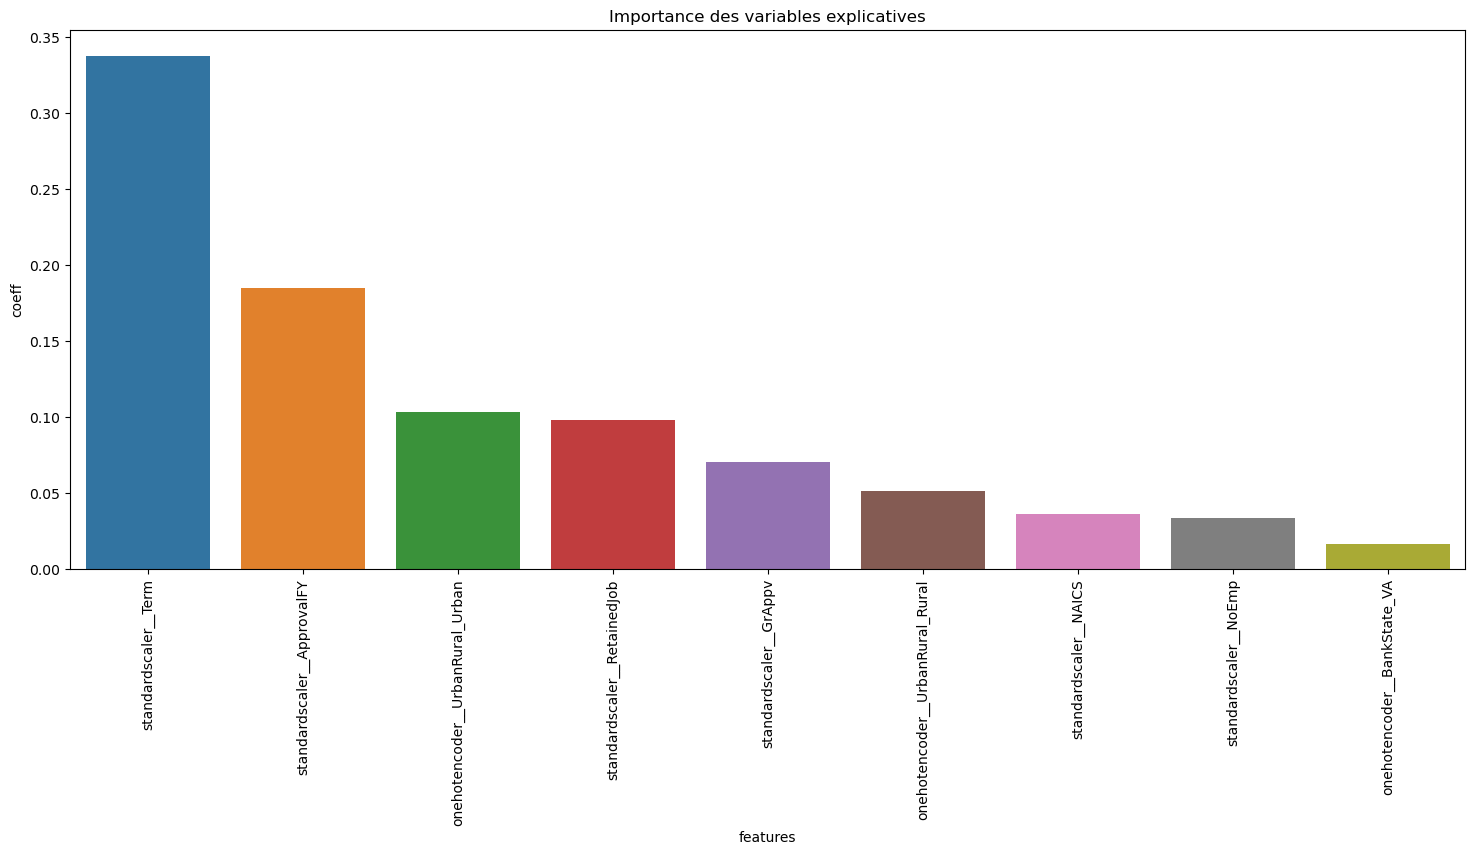

In [164]:
plt.figure(figsize=(18,7))
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [187]:
# fig = plt.figure(figsize=(30,20))
# plot_tree(forest.named_steps['randomforestclassifier'].estimators_[0],filled=True)
# plt.show()

In [169]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005,
            tree_method = 'hist'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)

cross_val=cross_validate(xgb, X_train, y_train,scoring='f1_macro',cv=5)
cross_val['test_score'].mean()

0.8975996424799485

In [170]:
xgb.predict_proba(X_train)

array([[0.0049991 , 0.9950009 ],
       [0.7186719 , 0.28132805],
       [0.03884357, 0.9611564 ],
       ...,
       [0.46338212, 0.5366179 ],
       [0.00447315, 0.99552685],
       [0.00615001, 0.99385   ]], dtype=float32)

In [171]:
df.columns

Index(['State', 'BankState', 'NAICS', 'ApprovalFY', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural', 'MIS_Status',
       'GrAppv', 'Franchise'],
      dtype='object')

In [172]:
test = np.array(['NY','NY',11,1997,150,600,'New',15,10,'Urban',10000,'Without'])
dict_test = dict(zip(X.columns,test))
df_test = pd.DataFrame(dict_test, index=[0])


In [173]:
xgb.predict(df_test)[0]

1

In [174]:
f1_score(y_train,y_pred, average='macro')

0.7508282258687005

In [193]:
f1_score(y_train,y_pred, average='micro')

0.9385340375616816

In [175]:
y_pred = (xgb.predict_proba(X_train)[:,1] >= 0.3).astype(bool)
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.71      0.80    134333
           1       0.94      0.99      0.96    649125

    accuracy                           0.94    783458
   macro avg       0.93      0.85      0.88    783458
weighted avg       0.94      0.94      0.94    783458



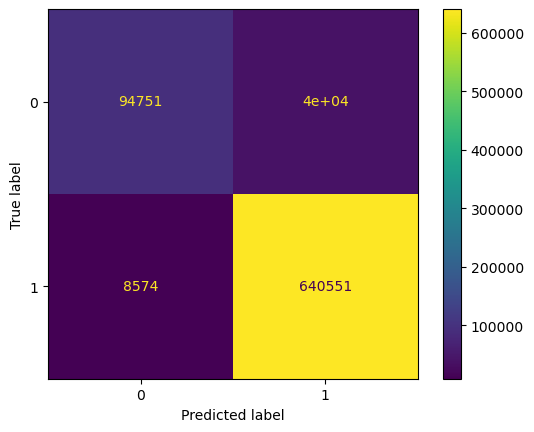

In [176]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [184]:
with open('../Files/xgbModel.pkl', 'wb') as file:
  pickle.dump(xgb, file)


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870509 entries, 0 to 870508
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        870509 non-null  object 
 1   BankState    869009 non-null  object 
 2   NAICS        870509 non-null  int64  
 3   ApprovalFY   870509 non-null  int64  
 4   Term         870509 non-null  int64  
 5   NoEmp        870509 non-null  int64  
 6   NewExist     870509 non-null  object 
 7   CreateJob    870509 non-null  int64  
 8   RetainedJob  870509 non-null  int64  
 9   UrbanRural   870509 non-null  object 
 10  MIS_Status   870509 non-null  int64  
 11  GrAppv       870509 non-null  float64
 12  Franchise    870509 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 86.3+ MB
